# WSI - laboratorium 5

Zadanie: "Sztuczne sieci neuronowe"

Autorzy: Michał Brus (299106) i Jakub Mazurkiewicz (300226)

## Wczytywanie zbioru MNIST

### Klasa bazowa

Poniższa klasa jest klasą bazową dla zbiorów obrazów ręcznie ręcznie rysowanych cyfr o rozmiarach 8x8 oraz 28x28 pikseli.

In [1]:
class MnistSetBase:
    def __init__(self):
        self.training_set = []
        self.validating_set = []
        self.testing_set = []

    def get_training_set(self):
        return self.training_set

    def get_validating_set(self):
        return self.validating_set

    def get_testing_set(self):
        return self.training_set

### Zbiór obrazów 8x8

Zbiór obrazów 8x8 pochodzi z pakietu `sklearn`.

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

class MnistSet8(MnistSetBase):
    def __init__(self):
        digits = load_digits()
        images = [(self._adjust_pixels(pixels), label) for pixels, label in zip(digits.data, digits.target)]
        self.training_set, self.testing_set = train_test_split(images)
        self.training_set, self.validating_set = train_test_split(self.training_set)

    def _adjust_pixels(self, pixels):
        return [pixel / 16 for pixel in pixels]

### Zbiór obrazów 28x28

Zbiór obrazów 28x28 pochodzi ze strony internetowej [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/).

In [3]:
class MnistSet28(MnistSetBase):
    def __init__(self):
        self.training_set = self._read_set('train-labels.idx1-ubyte', 'train-images.idx3-ubyte')
        self.training_set, self.validating_set = train_test_split(self.training_set)
        self.testing_set = self._read_set('t10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte')

    def _read_set(self, labels_filename, pixels_filename):
        return [
            (self._adjust_pixels(pixels), label) for pixels, label
            in zip(self._read_pixels(pixels_filename), self._read_labels(labels_filename))
        ]
    
    def _adjust_pixels(self, pixels):
        return [pixel / 255 for pixel in pixels]

    def _read_labels(self, filename: str):
        with open(filename, 'rb') as file:
            assert int.from_bytes(file.read(2), byteorder='big') == 0
            assert int.from_bytes(file.read(1), byteorder='big') == 0x08
            assert int.from_bytes(file.read(1), byteorder='big') == 1
            label_count = int.from_bytes(file.read(4), byteorder='big')
            return [int.from_bytes(file.read(1), byteorder='big') for _ in range(label_count)]

    def _read_pixels(self, filename: str):
        with open(filename, 'rb') as file:
            image_count, image_size = self._read_pixels_header(file)
            return [file.read(image_size) for _ in range(image_count)]

    def _read_pixels_header(self, file):
        assert int.from_bytes(file.read(2), byteorder='big') == 0
        assert int.from_bytes(file.read(1), byteorder='big') == 0x08
        assert int.from_bytes(file.read(1), byteorder='big') == 3
        dims = [int.from_bytes(file.read(4), byteorder='big') for _ in range(3)]
        return dims[0], dims[1] * dims[2]

## Przygotowanie sztucznej sieci neuronowej

### Przyjęte funkcje aktywacji

In [4]:
import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Przyjęte funkcje straty

In [5]:
def loss(predicted_y, expected_y):
    return np.square(predicted_y - expected_y)

def loss_derivative(predicted_y, expected_y):
    return 2 * (predicted_y - expected_y)

### Klasa reprezentująca sztuczną sieć neuronową

In [6]:
from numpy.random import default_rng

def chunks(r, n):
    for i in range(0, len(r), n):
        yield r[i:i+n]

class Network:
    def __init__(self, neurons_per_layer):
        self.number_of_layers = len(neurons_per_layer)
        self.neurons_per_layer = neurons_per_layer
        self.rng = default_rng()
        inv_sqrt_first_layer_size = 1 / np.sqrt(neurons_per_layer[0])
        self.biases = [self.rng.uniform(-inv_sqrt_first_layer_size, inv_sqrt_first_layer_size, size=(y, 1))
                       for y in neurons_per_layer[1:]]
        self.weights = [self.rng.uniform(-inv_sqrt_first_layer_size, inv_sqrt_first_layer_size, size=(y, x))
                        for x, y in zip(neurons_per_layer[:-1], neurons_per_layer[1:])]

    def feedforward(self, a):
        a = np.reshape(a, (-1, 1))
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def sgd(self, training_data, mini_batch_size, learning_rate):
        n = len(training_data)
        self.rng.shuffle(training_data)
        mini_batches = chunks(training_data, mini_batch_size)
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, learning_rate)

    def update_mini_batch(self, mini_batch, learning_rate):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(np.reshape(x, (-1, 1)), y)
            nabla_b = [nb + d_nb for nb, d_nb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + d_nw for nw, d_nw in zip(nabla_w, delta_nabla_w)]
        self.biases = [b - (nb * learning_rate / len(mini_batch)) for b, nb in zip(self.biases, nabla_b)]
        self.weights = [w - (nw * learning_rate / len(mini_batch)) for w, nw in zip(self.weights, nabla_w)]

    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        z_vectors = []
        for b, w in zip(self.biases, self.weights):
            z_vector = np.dot(w, activation) + b
            z_vectors.append(z_vector)
            activation = sigmoid(z_vector)
            activations.append(activation)
        delta = loss_derivative(activations[-1], self.one_hot_encode(y)) * sigmoid_derivative(z_vectors[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, np.transpose(activations[-2]))

        for i in range(2, self.number_of_layers):
            z_vector = z_vectors[-i]
            delta = np.dot(self.weights[-i + 1].transpose(), delta) * sigmoid_derivative(z_vector)
            nabla_b[-i] = delta
            nabla_w[-i] = np.dot(delta, np.transpose(activations[-i - 1]))
        return nabla_b, nabla_w

    def evaluate(self, data_set):
        results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data_set]
        return sum(int(x == y) for (x, y) in results)

    def mse(self, test_data):
        err = [loss(self.feedforward(x), self.one_hot_encode(y)) for (x, y) in test_data]
        mean_err = np.mean(err)
        return mean_err

    def one_hot_encode(self, j):
        e = np.zeros((10, 1))
        e[j] = 1.0
        return e

## Eksperymenty

### Funkcja wspomagająca przeprowadzanie eksperymentów

In [12]:
import matplotlib.pyplot as plt

def simulation(network_layers, epochs, mini_batch_size, learning_rate):
    network = Network(network_layers)
    accuracy_history = []
    mse_history = []
    
    print('Starting simulation...')
    for i in range(epochs):
        network.sgd(training_set, mini_batch_size, learning_rate)
        valid_goods = network.evaluate(validating_set)
        valid_accuracy = valid_goods / len(validating_set) * 100
        goods = network.evaluate(testing_set)
        accuracy = goods / len(testing_set) * 100
        accuracy_history.append(accuracy)
        mse = network.mse(testing_set)
        mse_history.append(mse)
        info = f'Epoch {i+1}/{epochs}'
        print(f'{info:<15} -> valid_accuracy={valid_accuracy:.2f}%, accuracy={accuracy:.2f}%, mse={mse:.5f}')
        
    plt.figure()
    plt.plot(range(1, epochs+1), accuracy_history)
    plt.xlabel('Numer epoki')
    plt.ylabel('Procent trafień')
    plt.title('Trafienia sieci neuronowej w zależności od epoki')
    plt.grid(True)
    plt.figure()
    plt.plot(range(1, epochs+1), mse_history)
    plt.xlabel('Numer epoki')
    plt.ylabel('Błąd średniokwadratowy')
    plt.title('Błąd średniokwadratowy w zależności od epoki')
    plt.grid(True)
    plt.show()

### Testy na zbiorze `MnistSet8`

#### Załadowanie zbioru

In [13]:
mnist = MnistSet8()
training_set = mnist.get_training_set()
validating_set = mnist.get_validating_set()
testing_set = mnist.get_testing_set()

#### Eksperyment 1

Starting simulation...
Epoch 1/30      -> valid_accuracy=6.23%, accuracy=10.69%, mse=0.09022
Epoch 2/30      -> valid_accuracy=8.31%, accuracy=10.59%, mse=0.09017
Epoch 3/30      -> valid_accuracy=9.79%, accuracy=9.80%, mse=0.09037
Epoch 4/30      -> valid_accuracy=11.87%, accuracy=10.10%, mse=0.09036
Epoch 5/30      -> valid_accuracy=21.36%, accuracy=20.59%, mse=0.08944
Epoch 6/30      -> valid_accuracy=24.93%, accuracy=27.52%, mse=0.07973
Epoch 7/30      -> valid_accuracy=27.60%, accuracy=30.89%, mse=0.07452
Epoch 8/30      -> valid_accuracy=47.48%, accuracy=50.00%, mse=0.06462
Epoch 9/30      -> valid_accuracy=61.13%, accuracy=64.85%, mse=0.04816
Epoch 10/30     -> valid_accuracy=72.70%, accuracy=78.61%, mse=0.03226
Epoch 11/30     -> valid_accuracy=79.23%, accuracy=85.45%, mse=0.02402
Epoch 12/30     -> valid_accuracy=82.79%, accuracy=87.33%, mse=0.02106
Epoch 13/30     -> valid_accuracy=89.91%, accuracy=92.08%, mse=0.01670
Epoch 14/30     -> valid_accuracy=80.12%, accuracy=82.38%,

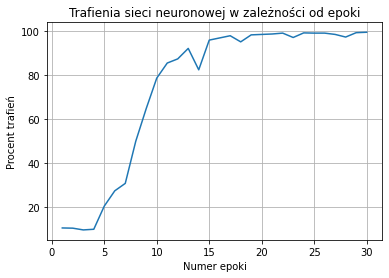

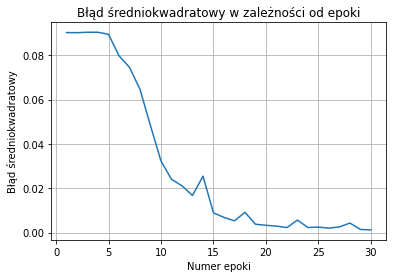

In [15]:
simulation(network_layers=[64, 16, 16, 10], epochs=30, mini_batch_size=10, learning_rate=3.0)

### Testy na zbiorze `MnistSet28`

#### Załadowanie zbioru

In [16]:
mnist = MnistSet28()
training_set = mnist.get_training_set()
validating_set = mnist.get_validating_set()
testing_set = mnist.get_testing_set()

#### Eksperyment 1

Starting simulation...
Epoch 1/20      -> valid_accuracy=91.19%, accuracy=91.57%, mse=0.01431
Epoch 2/20      -> valid_accuracy=91.45%, accuracy=91.98%, mse=0.01267
Epoch 3/20      -> valid_accuracy=92.27%, accuracy=92.81%, mse=0.01176
Epoch 4/20      -> valid_accuracy=92.71%, accuracy=93.38%, mse=0.01129
Epoch 5/20      -> valid_accuracy=92.07%, accuracy=92.58%, mse=0.01200
Epoch 6/20      -> valid_accuracy=92.61%, accuracy=93.51%, mse=0.01091
Epoch 7/20      -> valid_accuracy=92.85%, accuracy=93.86%, mse=0.01034
Epoch 8/20      -> valid_accuracy=92.73%, accuracy=93.61%, mse=0.01032
Epoch 9/20      -> valid_accuracy=92.88%, accuracy=93.74%, mse=0.01048
Epoch 10/20     -> valid_accuracy=92.85%, accuracy=93.51%, mse=0.01079
Epoch 11/20     -> valid_accuracy=93.20%, accuracy=94.49%, mse=0.00927
Epoch 12/20     -> valid_accuracy=93.17%, accuracy=94.43%, mse=0.00926
Epoch 13/20     -> valid_accuracy=93.32%, accuracy=94.51%, mse=0.00926
Epoch 14/20     -> valid_accuracy=93.05%, accuracy=94.

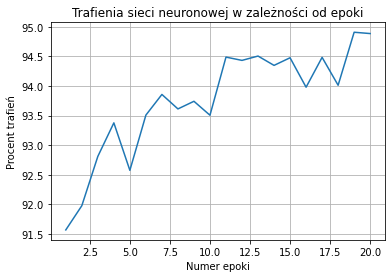

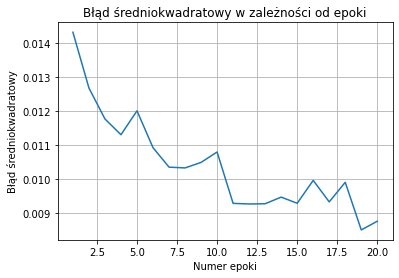

In [17]:
simulation(network_layers=[784, 16, 10], epochs=20, mini_batch_size=10, learning_rate=3.0)